<a href="https://colab.research.google.com/github/pawara101/notebooks/blob/main/Housing_data_set_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
ERROR: Operation cancelled by user


In [ ]:
! mkdir ~/.kaggle

In [ ]:
! cp kaggle.json ~/.kaggle/

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle competitions download -c home-data-for-ml-course

  0% 0.00/386k [00:00<?, ?B/s]
100% 386k/386k [00:00<00:00, 64.7MB/s]


In [ ]:
! unzip home-data-for-ml-course.zip

Archive:  home-data-for-ml-course.zip
  inflating: data_description.txt    
  inflating: sample_submission.csv   
  inflating: sample_submission.csv.gz  
  inflating: test.csv                
  inflating: test.csv.gz             
  inflating: train.csv               
  inflating: train.csv.gz            


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Read the data
X_full = pd.read_csv('/content/train.csv', index_col='Id')
X_test_full = pd.read_csv('/content/test.csv', index_col='Id')

# Remove rows with missing target, separate target from predictors
X_full.dropna(axis=0, subset=['SalePrice'], inplace=True)
y = X_full.SalePrice
X_full.drop(['SalePrice'], axis=1, inplace=True)

# Break off validation set from training data
X_train_full, X_valid_full, y_train, y_valid = train_test_split(X_full, y, 
                                                                train_size=0.8, test_size=0.2,
                                                                random_state=0)

# "Cardinality" means the number of unique values in a column
# Select categorical columns with relatively low cardinality (convenient but arbitrary)
categorical_cols = [cname for cname in X_train_full.columns if
                    X_train_full[cname].nunique() < 10 and 
                    X_train_full[cname].dtype == "object"]

# Select numerical columns
numerical_cols = [cname for cname in X_train_full.columns if 
                X_train_full[cname].dtype in ['int64', 'float64']]

# Keep selected columns only
my_cols = categorical_cols + numerical_cols
X_train = X_train_full[my_cols].copy()
X_valid = X_valid_full[my_cols].copy()
X_test = X_test_full[my_cols].copy()

In [ ]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error

# Preprocessing for numerical data
numerical_transformer = SimpleImputer(strategy='constant')

# Preprocessing for categorical data
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Bundle preprocessing for numerical and categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

# Define model
model = RandomForestRegressor(n_estimators=100, random_state=0)

# Bundle preprocessing and modeling code in a pipeline
clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('model', model)
                     ])

# Preprocessing of training data, fit model 
clf.fit(X_train, y_train)

# Preprocessing of validation data, get predictions
preds = clf.predict(X_valid)

print('MAE:', mean_absolute_error(y_valid, preds))

MAE: 17861.780102739725


## Cross-Validation

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Read the data
train_data = pd.read_csv('/content/train.csv', index_col='Id')
test_data = pd.read_csv('/content/test.csv', index_col='Id')

# Remove rows with missing target, separate target from predictors
train_data.dropna(axis=0, subset=['SalePrice'], inplace=True)
y = train_data.SalePrice              
train_data.drop(['SalePrice'], axis=1, inplace=True)

# Select numeric columns only
numeric_cols = [cname for cname in train_data.columns if train_data[cname].dtype in ['int64', 'float64']]
X = train_data[numeric_cols].copy()
X_test = test_data[numeric_cols].copy()

In [ ]:
X.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
Id,,,,,,,,,,,,,,,,,,,,,
1,60,65.0,8450,7,5,2003,2003,196.0,706,0,...,548,0,61,0,0,0,0,0,2,2008
2,20,80.0,9600,6,8,1976,1976,0.0,978,0,...,460,298,0,0,0,0,0,0,5,2007
3,60,68.0,11250,7,5,2001,2002,162.0,486,0,...,608,0,42,0,0,0,0,0,9,2008
4,70,60.0,9550,7,5,1915,1970,0.0,216,0,...,642,0,35,272,0,0,0,0,2,2006
5,60,84.0,14260,8,5,2000,2000,350.0,655,0,...,836,192,84,0,0,0,0,0,12,2008


In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

my_pipeline = Pipeline(steps=[
    ('preprocessor', SimpleImputer()),
    ('model', RandomForestRegressor(n_estimators=50, random_state=0))
])

In [ ]:
from sklearn.model_selection import cross_val_score

# Multiply by -1 since sklearn calculates *negative* MAE
scores = -1 * cross_val_score(my_pipeline, X, y,
                              cv=3,
                              scoring='neg_mean_absolute_error')
print('scores',scores)
print("Average MAE score:", scores.mean())

scores [18414.4198768  17950.8061191  18696.29205761]
Average MAE score: 18353.8393511688


In [ ]:
def get_score(n_estimators):
    """Return the average MAE over 3 CV folds of random forest model.
    
    Keyword argument:
    n_estimators -- the number of trees in the forest
    """
    # Replace this body with your own code
    n=n_estimators
    my_pipeline = Pipeline(steps=[
                ('preprocessor', SimpleImputer()),
                ('model', RandomForestRegressor(n_estimators=n, random_state=0))
                    ])
    
    scores = -1 * cross_val_score(my_pipeline, X, y,
                              cv=3,
                              scoring='neg_mean_absolute_error')

    return scores.mean()

In [ ]:
results = dict() # Your code here

for k in range(50,450,50):
    avg_MAE = get_score(k)
    results[k] = avg_MAE

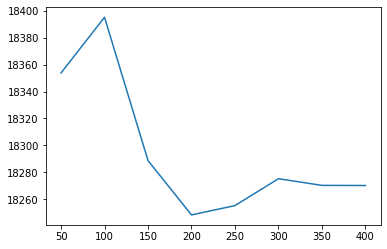

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(list(results.keys()), list(results.values()))
plt.show()

In [ ]:
n_estimators_best = min(results, key=results.get)

## Gradient-Boosting

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Read the data
X = pd.read_csv('/content/train.csv', index_col='Id')
X_test_full = pd.read_csv('/content/test.csv', index_col='Id')

# Remove rows with missing target, separate target from predictors
X.dropna(axis=0, subset=['SalePrice'], inplace=True)
y = X.SalePrice              
X.drop(['SalePrice'], axis=1, inplace=True)

# Break off validation set from training data
X_train_full, X_valid_full, y_train, y_valid = train_test_split(X, y, train_size=0.8, test_size=0.2,
                                                                random_state=0)

# "Cardinality" means the number of unique values in a column
# Select categorical columns with relatively low cardinality (convenient but arbitrary)
low_cardinality_cols = [cname for cname in X_train_full.columns if X_train_full[cname].nunique() < 10 and 
                        X_train_full[cname].dtype == "object"]

# Select numeric columns
numeric_cols = [cname for cname in X_train_full.columns if X_train_full[cname].dtype in ['int64', 'float64']]

# Keep selected columns only
my_cols = low_cardinality_cols + numeric_cols
X_train = X_train_full[my_cols].copy()
X_valid = X_valid_full[my_cols].copy()
X_test = X_test_full[my_cols].copy()

# One-hot encode the data (to shorten the code, we use pandas)
X_train = pd.get_dummies(X_train)
X_valid = pd.get_dummies(X_valid)
X_test = pd.get_dummies(X_test)
X_train, X_valid = X_train.align(X_valid, join='left', axis=1)
X_train, X_test = X_train.align(X_test, join='left', axis=1)

In [ ]:
from xgboost import XGBRegressor

# Define the model
my_model_1 = XGBRegressor()# Your code here

# Fit the model
my_model_1.fit(X_train, y_train) # Your code here


In [ ]:
from sklearn.metrics import mean_absolute_error

# Get predictions
predictions_1 = my_model_1.predict(X_valid) # Your code here

# Calculate MAE
mae_1 = mean_absolute_error(predictions_1,y_valid) # Your code here

# Uncomment to print MAE
print("Mean Absolute Error:" , mae_1)

In [ ]:
# Define the model
my_model_2 = XGBRegressor(n_estimators = 300,learning_rate = 0.05) # Your code here

# Fit the model
my_model_2.fit(X_train, y_train)# Your code here

# Get predictions
predictions_2 = my_model_2.predict(X_valid) # Your code here

# Calculate MAE
mae_2 = mean_absolute_error(predictions_2, y_valid) # Your code here

# Uncomment to print MAE
print("Mean Absolute Error:" , mae_2)

In [ ]:
# Define the model
my_model_3 = XGBRegressor(n_estimators = 500,learning_rate = 0.5)

# Fit the model
my_model_3.fit(X_train, y_train) # Your code here

# Get predictions
predictions_3 = my_model_3.predict(X_valid)

# Calculate MAE
mae_3 = mean_absolute_error(predictions_3, y_valid)

# Uncomment to print MAE
print("Mean Absolute Error:" , mae_3)

In [ ]:
def model(n):
  myModel = XGBRegressor(n_estimators = n,learning_rate = 0.05)
  myModel.fit(X_train, y_train)

  predictions = myModel.predict(X_valid)

  Mae = mean_absolute_error(predictions,y_valid)
  return Mae

MeanAbsErr= list()
for n in range(100,1050,50):
  MAE = model(n)
  MeanAbsErr.append(MAE)

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(range(100,1050,50),MeanAbsErr)
plt.show()